## Additional Packages

In [1]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 7.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=bb84ab4974f730d9da0aa1d6a75c469b9920fcd2243c8248de6b21e54db225f7
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=a5b8292ed071bea82a6f2ecd98cba78e35c5405a785727c68377ba930ed85020
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


## Imports

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image

## Configuration

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Input size for generator
INPUT_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 200

SRC_PATH = '/kaggle/input/house-rooms-streets-image-dataset/kaggle_room_street_data/street_data'

INPUT_DIR = 'images'
TRAIN_PATH = f'{INPUT_DIR}/train'
TEST_PATH = f'{INPUT_DIR}/test'

OUTPUT_DIR = 'output'

## Setting Up Dataset Directory

In [4]:
if not os.path.exists(INPUT_DIR):
    os.makedirs(TRAIN_PATH)
    os.makedirs(TEST_PATH)
    
num_images_to_use = 1000
names = os.listdir(SRC_PATH)[:num_images_to_use]
train_names, test_names = train_test_split(names, test_size=0.1, random_state=10)

for img in train_names:
    shutil.copyfile(os.path.join(SRC_PATH, img), os.path.join(TRAIN_PATH, img))
    
for img in test_names:
    shutil.copyfile(os.path.join(SRC_PATH, img), os.path.join(TEST_PATH, img))

## Discriminator

In [5]:
class CNN_Block(nn.Module):
    def __init__(self,in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False, padding_mode='reflect'),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )
        
    def forward(self, x):
        return self.conv(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        layers = []
        
        # First
        # Does not use BatchNorm
        layers.append(nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'))
        layers.append(nn.LeakyReLU(0.2))
        
        layers.append(CNN_Block(64, 128, stride=2))
        layers.append(CNN_Block(128, 256, stride=2))
        layers.append(CNN_Block(256, 512, stride=1))
        
        # Last
        # Reducing number of channels to 1
        # Output size = (N, C, H, W) = (batch_size, 1, 30, 30)
        layers.append(
            nn.Conv2d(
                512, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'
            )
        )
        
        self.model = nn.Sequential(*layers)
        
    def forward(self,x,y):
        x = torch.cat([x,y],dim=1)
        return self.model(x)

## Dataset Class

In [7]:
class Images_Dataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.images_path = images_path
        self.images = os.listdir(images_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_path, self.images[idx])
        colored = Image.open(img_path).convert('RGB')
        grayscale = colored.convert('L')
        
        name = os.path.splitext(self.images[idx])[0]

        
        if self.transform is not None:
            grayscale = self.transform(grayscale)
            colored = self.transform(colored)
        
        return grayscale, colored, name

## Data Loaders

In [8]:
transform = transforms.Compose([transforms.Resize(INPUT_SIZE), transforms.ToTensor()])

train_dataset = Images_Dataset(TRAIN_PATH, transform)
test_dataset = Images_Dataset(TEST_PATH, transform)

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, num_workers=2)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, num_workers=2)

## Setting Up Training

In [9]:
%%capture
generator = smp.Unet(encoder_name='resnet18', encoder_weights='imagenet', in_channels=1, classes=3, activation='tanh')
# Telling model to use multiple GPUs
generator= nn.DataParallel(generator)
generator.to(DEVICE)

discriminator = Discriminator(in_channels=1+3)
#Telling model to use multiple GPUs
discriminator= nn.DataParallel(discriminator)
discriminator.to(DEVICE)

In [10]:
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_generator = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

BCE = nn.BCEWithLogitsLoss()
L1 = nn.L1Loss()

d_scaler = torch.cuda.amp.GradScaler()
g_scaler = torch.cuda.amp.GradScaler()

## Training

In [11]:
for epoch in range(EPOCHS):
    train = tqdm(train_dataloader, desc=f'Epoch {epoch+1}', colour='green')
    for grayscale, colored, _ in train:
        grayscale = grayscale.to(DEVICE)
        colored = colored.to(DEVICE)
        
        # Discriminator
        with torch.cuda.amp.autocast():
            generator_output = generator(grayscale)
            discriminator_output_real = discriminator(grayscale, colored)
            discriminator_output_generated = discriminator(grayscale, generator_output)
            
            real_loss = BCE(discriminator_output_real, torch.ones_like(discriminator_output_real))
            generated_loss = BCE(discriminator_output_generated, torch.zeros_like(discriminator_output_generated))
            
            total_loss = (real_loss + generated_loss) / 2
            
        optimizer_discriminator.zero_grad()
        d_scaler.scale(total_loss).backward(retain_graph=True)
        d_scaler.step(optimizer_discriminator)
        d_scaler.update()
        
        # Generator
        with torch.cuda.amp.autocast():
            discriminator_output_generated = discriminator(grayscale, generator_output)
            loss = BCE(discriminator_output_generated, torch.ones_like(discriminator_output_generated))
            loss += 100 * L1(generator_output, colored)
            
        optimizer_generator.zero_grad()
        g_scaler.scale(loss).backward()
        g_scaler.step(optimizer_generator)
        g_scaler.update()
        
        train.set_postfix({'Discriminator Loss': total_loss.item(), 'Generator Loss': loss.item()})

Epoch 200: 100%|██████████| 29/29 [00:11<00:00,  2.62it/s, Discriminator Loss=0.685, Generator Loss=2.92]


## Generating and Saving Outputs of Test Set

In [12]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
generator.eval()
test = tqdm(test_dataloader, colour='green')
for grayscale, colored, names in test:
    with torch.no_grad():
        grayscale = grayscale.to(DEVICE)
        outputs = generator(grayscale)
        
        for grayscale_original, colored_original, colored_generated, name in zip(grayscale, colored, outputs, names):
            save_image(grayscale_original, f'{OUTPUT_DIR}/{name}_0.jpg')
            save_image(colored_original, f'{OUTPUT_DIR}/{name}_1.jpg')
            save_image(colored_generated, f'{OUTPUT_DIR}/{name}_2.jpg')

100%|██████████| 4/4 [00:02<00:00,  2.00it/s]


## Plotting Saved Outputs

In [13]:
def plot_output(idx):
    total = len(os.listdir(TEST_PATH))
    if idx < 0 or idx >= total:
        print(f'Index cannot be less than 0 or > than {total-1}')
        return
    
    name = os.path.splitext(os.listdir(TEST_PATH)[idx])[0]
    grayscale = Image.open(f'{OUTPUT_DIR}/{name}_0.jpg').convert('L')
    colored_original = Image.open(f'{OUTPUT_DIR}/{name}_1.jpg').convert('RGB')
    colored_generated = Image.open(f'{OUTPUT_DIR}/{name}_2.jpg').convert('RGB')
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 15))
    fontsize = 20
    
    ax[0].set_title('Original Black and White', fontsize=fontsize)
    ax[0].imshow(grayscale, cmap='gray')

    ax[1].set_title('Original Colored', fontsize=fontsize)
    ax[1].imshow(colored_original)

    ax[2].set_title('Generated Colored', fontsize=fontsize)
    ax[2].imshow(colored_generated)

    plt.show()

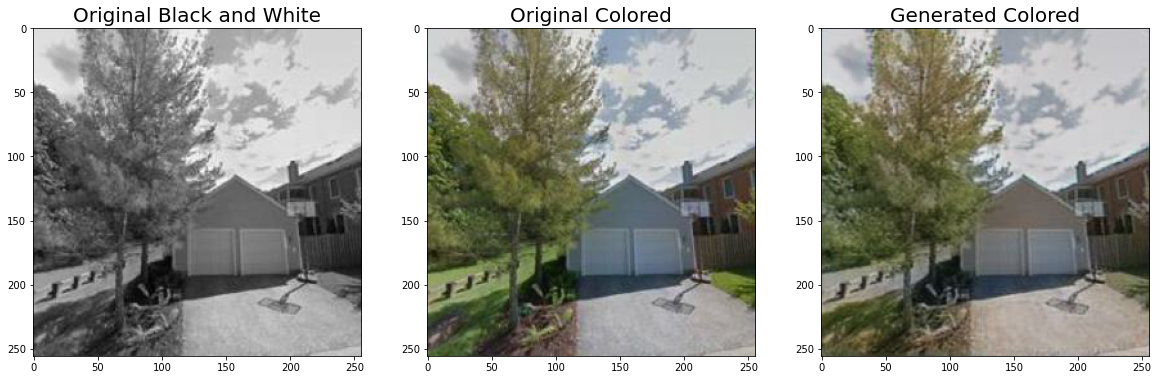

In [34]:
plot_output(0)

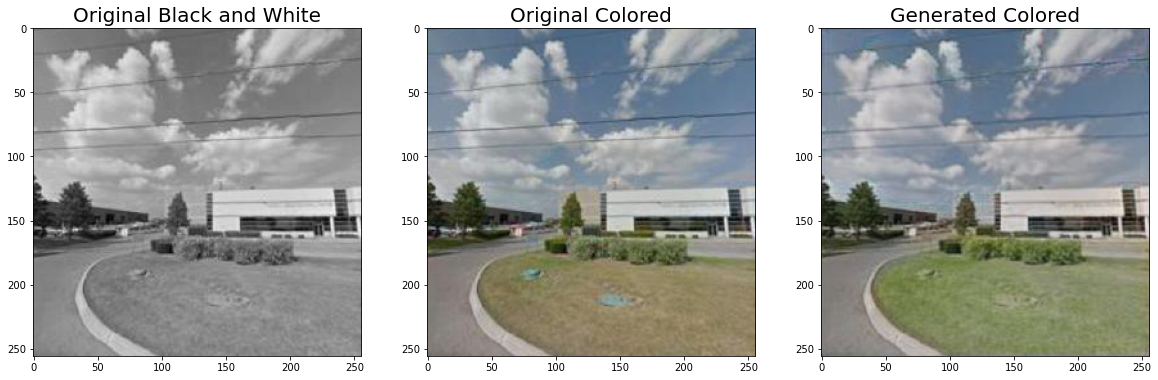

In [35]:
plot_output(11)

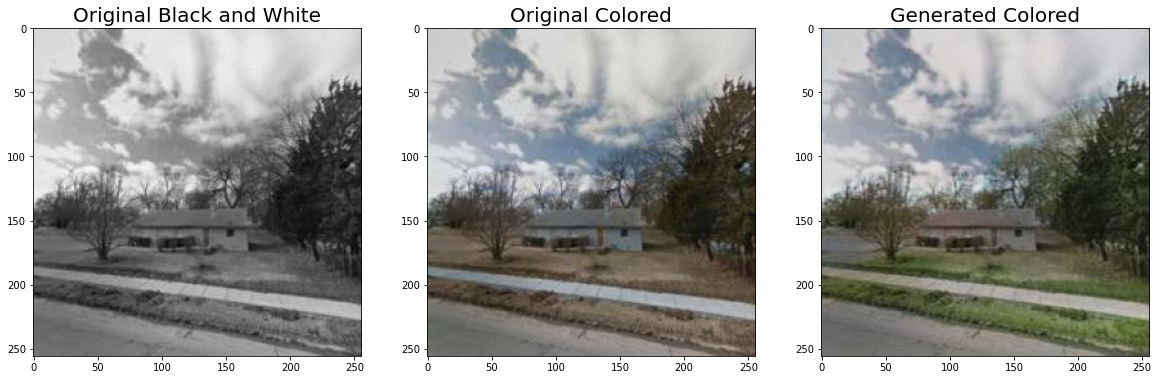

In [41]:
plot_output(17)